In [1099]:
import numpy as np
import torch, argparse, json
import torch.nn as nn # layer types
import torch.nn.functional as func # useful ML functions (activations) that are applied to layers
import torch.optim as optim
import matplotlib.pyplot as plt

#hypers = learning_rate, num_epochs, display_epochs, batch_size, nhidden
learning_rate = 1e-2
num_epochs = 20
display_epochs = num_epochs/5
batch_size = 500
nhidden = 100

In [1100]:
n_bits = 14*14
data = np.loadtxt(fname="inputs\even_mnist.csv")
train = data[:-3000]
test = data[-3000:]
#x_train = data[:-3000,:-1]
x_train = train[:batch_size,:-1]
x_train = np.array(x_train, dtype = np.float32)
#y_train = data[:-3000,-1]
y_train = train[:batch_size,-1]
#print(x_train)
#print(y_train)
x_test = data[-3000:,:-1]
x_test = np.array(x_test, dtype = np.float32)
y_test = data[-3000:,-1]
#print('\n\n',x_test)
#print(y_test)

#print('\n\n',len(x_train))
#print(len(y_train))
#print(len(x_test))
#print(len(y_test))

In [1101]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        # super gives access to attributes in a superclass from the subclass that inherits from it
        self.fc1= nn.Linear(n_bits, nhidden)
        #layer 1 (input set, hidden layer bits)
        self.fc2= nn.Linear(nhidden, 10) 
        #layer 2 (hidden, final y output)
    #forward pass through layers
    def forward(self, x):
        h = func.relu(self.fc1(x))
        #h is output from first layer from input x
        y = func.softmax(self.fc2(h), dim=1) #dim=0 or 1?
        return y
    
    #clears parameters so code can be run again?
    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [1102]:
model = Net().to(torch.device("cpu")) # inheritance!

In [1103]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # not really going to do SGD...
#model.parameters is created from nn.Module in Net class inheritance

In [1104]:
inputs = torch.from_numpy(x_train) #[:batch_size,:]
#print(inputs)
# #changes inputs to pytorch tensers

In [1105]:
targets = torch.from_numpy(y_train) # need an extra "superfluous" dimension // [:batch_size]
targets = targets.type(torch.LongTensor)
#print(targets)
# print(targets.size()) 
# #targets = torch.reshape(targets, (-1, 1))
# #print(targets.size()) 
# #need to reshape since pytorch has trouble with it (200 data sets printing 1 output each)

In [1106]:
# inputs.size()

In [1107]:
# model.forward(inputs).size()

In [1108]:
loss = nn.NLLLoss(reduction='mean') #negative log likelyhood
loss(model.forward(inputs), targets)
#compares calculated y vals with provided to find difference?
#targets = targets.type(torch.LongTensor)

tensor(-0.0391, grad_fn=<NllLossBackward>)

In [1109]:
# obj_vals= []

# for epoch in range(num_epochs):   
#     obj_val = loss(model.forward(inputs), targets)
    
#     optimizer.zero_grad() # clear any previous gradients
#     obj_val.backward() # backprop step, calculates gradient values
#     optimizer.step() # apply gradients to model parameters
    
#     obj_vals.append(obj_val.item()) #adds loss val to list
#     if (epoch+1) % display_epochs == 0:
#         print ('Epoch [{}/{}]\tLoss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))

In [1110]:
# plt.plot(range(num_epochs), obj_vals)

In [1111]:
# #testing model on new dataset (made the same way)
# #set aside some of the original data to use for this in the assignment

# with torch.no_grad():
#     inputs = torch.from_numpy(x_test)
#     targets = torch.from_numpy(y_test)
#     targets = targets.type(torch.LongTensor)
#     #targets = torch.reshape(targets, (-1, 1))
#     print(inputs.size())
#     print(targets.size())
#     cross_val = loss(model.forward(inputs), targets)
    
# print(cross_val)
# #test data performance is expected to be worse than training data performance

In [1112]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [1113]:
#train and test in one loop
obj_vals= []
obj_accs= []
cross_vals= []
cross_accs= []

model.reset() # reset your parameters

for epoch in range(num_epochs):
    #Training
    batch_index = 0
    correct = 0
    #next_batch = batch_index + batch_size
    temp_vals= []
    for batch_index in batch(train, batch_size):
    #while next_batch<len(train):
        #print(batch_index)
        #x_t = train[batch_index:next_batch,:-1]
        #y_t = train[batch_index:next_batch,-1]
        x_t = batch_index[:,:-1]
        y_t = batch_index[:,-1]
        x_t = np.array(x_t, dtype = np.float32)
        inputs = torch.from_numpy(x_t)
        targets = torch.from_numpy(y_t)
        #inputs = torch.from_numpy(x_train)
        #targets = torch.from_numpy(y_train)
        #print(targets)
        targets = targets.type(torch.LongTensor)
        #targets = torch.reshape(targets, (-1, 1))
        
        temp_val = 10**(loss(model.forward(inputs), targets))
        #print(model(inputs))

        optimizer.zero_grad()
        temp_val.backward()
        optimizer.step()

        #obj_acc = (model.forward(inputs)==targets).float().sum()
        #obj_acc = 100*loss(model.forward(inputs)/targets)

        temp_vals.append(temp_val.item())
        #obj_accs.append(obj_accs.item())
        output = torch.max(model(inputs), dim=1)[1].squeeze()
        correct += (output == targets).float().sum()
        #print(output.indices)
        #if output == targets:
        #    correct += 1
        #    print("aye")
        
    obj_val = np.average(temp_vals)
    obj_vals.append(obj_val.item())
    obj_accs.append(100*correct/len(train))

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Training Loss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))
        print ('Epoch [{}/{}]\t Training Accuracy: {:.4f}%'.format(epoch+1, num_epochs, obj_accs[-1]))

    #Checking loss at each step to compare
    with torch.no_grad(): 
        correct_c = 0
        # don't track calculations in the following scope for the purposes of gradients
        inputs = torch.from_numpy(x_test)
        targets = torch.from_numpy(y_test)
        targets = targets.type(torch.LongTensor)
        #targets = torch.reshape(targets, (-1, 1))
        cross_val = 10**(loss(model.forward(inputs), targets))
        output_c = torch.max(model(inputs), dim=1)[1].squeeze()
        correct_c += (output_c == targets).float().sum()
        cross_vals.append(cross_val)
        cross_accs.append(100*correct_c/len(test))

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Test Loss: {:.4f}'.format(epoch+1, num_epochs, cross_val.item()))
        print ('Epoch [{}/{}]\t Test Accuracy: {:.4f}% \n'.format(epoch+1, num_epochs, cross_accs[-1]))

print('\n~~~~~~~~~~~~~~~~~~PERFORMANCE REPORT~~~~~~~~~~~~~~~~~~')
print('Final training performance: \n Loss: {:.4f} \t Accuracy: {:0.2f}%'.format(obj_vals[-1],obj_accs[-1]))
print('Final testing performance: \n Loss: {:.4f} \t Accuracy: {:0.2f}%'.format(cross_vals[-1],cross_accs[-1]))

Epoch [4/20]	 Training Loss: 0.2808
Epoch [4/20]	 Training Accuracy: 55.7527%
Epoch [4/20]	 Test Loss: 0.2657
Epoch [4/20]	 Test Accuracy: 57.6667% 

Epoch [8/20]	 Training Loss: 0.2696
Epoch [8/20]	 Training Accuracy: 57.3003%
Epoch [8/20]	 Test Loss: 0.2609
Epoch [8/20]	 Test Accuracy: 58.3000% 

Epoch [12/20]	 Training Loss: 0.2665
Epoch [12/20]	 Training Accuracy: 57.6816%
Epoch [12/20]	 Test Loss: 0.2589
Epoch [12/20]	 Test Accuracy: 58.7000% 

Epoch [16/20]	 Training Loss: 0.2646
Epoch [16/20]	 Training Accuracy: 57.9420%
Epoch [16/20]	 Test Loss: 0.2579
Epoch [16/20]	 Test Accuracy: 58.8333% 

Epoch [20/20]	 Training Loss: 0.2633
Epoch [20/20]	 Training Accuracy: 58.1383%
Epoch [20/20]	 Test Loss: 0.2570
Epoch [20/20]	 Test Accuracy: 59.0333% 


~~~~~~~~~~~~~~~~~~PERFORMANCE REPORT~~~~~~~~~~~~~~~~~~
Final training performance: 
 Loss: 0.2633 	 Accuracy: 58.14%
Final testing performance: 
 Loss: 0.2570 	 Accuracy: 59.03%


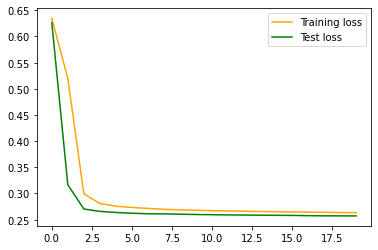

In [1114]:
plt.plot(range(num_epochs), obj_vals, label= "Training loss", color="orange")
plt.plot(range(num_epochs), cross_vals, label= "Test loss", color= "green")
plt.legend()

#mess around with things to try and match test to training
#assignment might ask for plot like this?